In [3]:
pip install requests pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
CITIES = {
    "Delhi": {"lat": 28.6139, "lon": 77.2090},
    "Mumbai": {"lat": 19.0760, "lon": 72.8777},
    "Bengaluru": {"lat": 12.9716, "lon": 77.5946},
    "Kolkata": {"lat": 22.5726, "lon": 88.3639}
}

In [5]:
import requests
import pandas as pd
import sqlite3

# -----------------------------
# CONFIG
# -----------------------------
CITIES = {
    "Delhi": {"lat": 28.6139, "lon": 77.2090},
    "Mumbai": {"lat": 19.0760, "lon": 72.8777},
    "Bengaluru": {"lat": 12.9716, "lon": 77.5946},
     "Kolkata": {"lat": 22.5726, "lon": 88.3639}
}

PARAMETERS = [
    "pm2_5",
    "pm10",
    "nitrogen_dioxide"
]

DB_NAME = "air_quality.db"
BASE_URL = "https://air-quality-api.open-meteo.com/v1/air-quality"

# -----------------------------
# DATABASE
# -----------------------------
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS air_quality (
    datetime_utc TEXT,
    city TEXT,
    pollutant TEXT,
    value REAL,
    latitude REAL,
    longitude REAL,
    source TEXT
)
""")

conn.commit()

# -----------------------------
# FETCH DATA
# -----------------------------
all_records = []

for city, coord in CITIES.items():
    print(f"Fetching data for {city}...")

    params = {
        "latitude": coord["lat"],
        "longitude": coord["lon"],
        "hourly": ",".join(PARAMETERS),
        "timezone": "UTC"
    }

    r = requests.get(BASE_URL, params=params)
    r.raise_for_status()
    data = r.json()

    times = data["hourly"]["time"]

    for param in PARAMETERS:
        values = data["hourly"][param]

        for t, v in zip(times, values):
            if v is not None:
                all_records.append({
                    "datetime_utc": t,
                    "city": city,
                    "pollutant": param,
                    "value": v,
                    "latitude": coord["lat"],
                    "longitude": coord["lon"],
                    "source": "Open-Meteo"
                })

df = pd.DataFrame(all_records)

df.to_sql("air_quality", conn, if_exists="append", index=False)
conn.close()

print("✅ Data ingestion successful.")


Fetching data for Delhi...
Fetching data for Mumbai...
Fetching data for Bengaluru...
Fetching data for Kolkata...
✅ Data ingestion successful.


In [6]:
import sqlite3, pandas as pd

conn = sqlite3.connect("air_quality.db")
pd.read_sql("""
SELECT city, pollutant, COUNT(*) AS n
FROM air_quality
GROUP BY city, pollutant
""", conn)

,city,pollutant,n
0,Bengaluru,nitrogen_dioxide,218
1,Bengaluru,pm10,218
2,Bengaluru,pm2_5,218
3,Chennai,nitrogen_dioxide,109
4,Chennai,pm10,109
5,Chennai,pm2_5,109
6,Delhi,nitrogen_dioxide,218
7,Delhi,pm10,218
8,Delhi,pm2_5,218
9,Kolkata,nitrogen_dioxide,109


In [7]:
import sqlite3
import pandas as pd

# Load data
conn = sqlite3.connect("air_quality.db")
df = pd.read_sql("SELECT * FROM air_quality", conn)
conn.close()

# Convert datetime
df["datetime_utc"] = pd.to_datetime(df["datetime_utc"])

# Sort properly
df = df.sort_values(["city", "pollutant", "datetime_utc"])

df.head()


,datetime_utc,city,location,pollutant,value,unit,latitude,longitude,source
872,2026-01-06 00:00:00,Bengaluru,None,nitrogen_dioxide,5.0,None,12.9716,77.5946,Open-Meteo
873,2026-01-06 01:00:00,Bengaluru,None,nitrogen_dioxide,7.5,None,12.9716,77.5946,Open-Meteo
874,2026-01-06 02:00:00,Bengaluru,None,nitrogen_dioxide,10.9,None,12.9716,77.5946,Open-Meteo
875,2026-01-06 03:00:00,Bengaluru,None,nitrogen_dioxide,12.5,None,12.9716,77.5946,Open-Meteo
876,2026-01-06 04:00:00,Bengaluru,None,nitrogen_dioxide,10.5,None,12.9716,77.5946,Open-Meteo


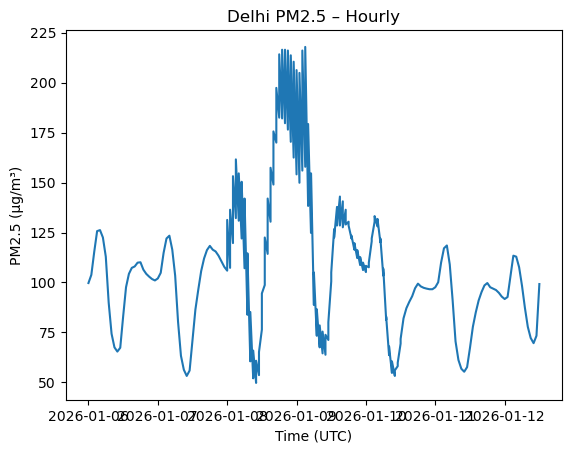

In [8]:
import matplotlib.pyplot as plt

subset = df[
    (df["city"] == "Delhi") &
    (df["pollutant"] == "pm2_5")
]

plt.figure()
plt.plot(subset["datetime_utc"], subset["value"])
plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Delhi PM2.5 – Hourly")
plt.show()

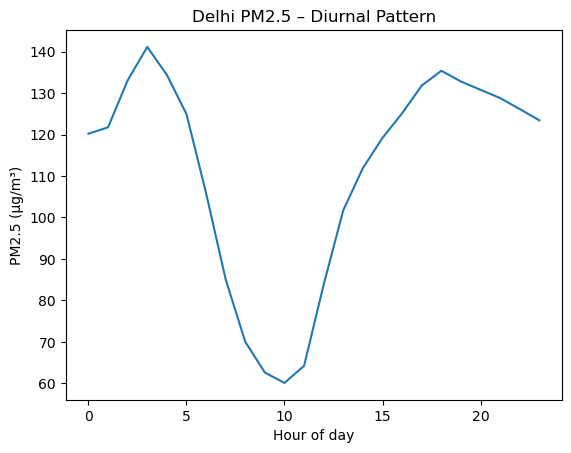

In [9]:
df["hour"] = df["datetime_utc"].dt.hour

diurnal = (
    df[(df["city"] == "Delhi") & (df["pollutant"] == "pm2_5")]
    .groupby("hour")["value"]
    .mean()
)

plt.figure()
plt.plot(diurnal.index, diurnal.values)
plt.xlabel("Hour of day")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Delhi PM2.5 – Diurnal Pattern")
plt.show()

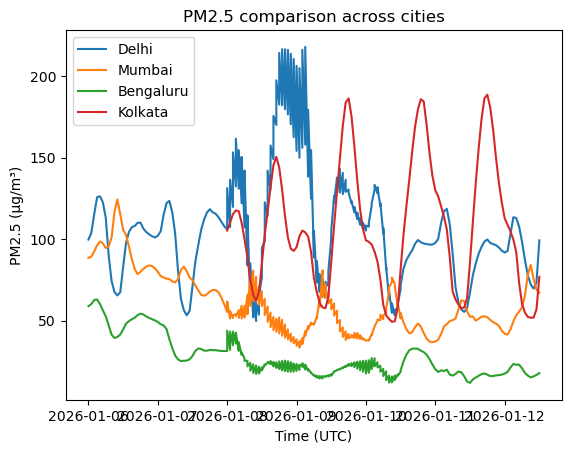

In [11]:
plt.figure()

for city in ["Delhi", "Mumbai", "Bengaluru", "Kolkata"]:
    temp = df[
        (df["city"] == city) &
        (df["pollutant"] == "pm2_5")
    ]
    plt.plot(temp["datetime_utc"], temp["value"], label=city)

plt.legend()
plt.title("PM2.5 comparison across cities")
plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()

In [12]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("air_quality.db")
df = pd.read_sql("SELECT * FROM air_quality", conn)
conn.close()

df["datetime_utc"] = pd.to_datetime(df["datetime_utc"])

# Filter Delhi PM2.5
ts = df[
    (df["city"] == "Delhi") &
    (df["pollutant"] == "pm2_5")
][["datetime_utc", "value"]]

ts = ts.rename(columns={
    "datetime_utc": "ds",
    "value": "y"
}).sort_values("ds")

ts.tail()

,ds,y
1412,2026-01-12 08:00:00,77.8
1413,2026-01-12 09:00:00,72.2
1414,2026-01-12 10:00:00,69.6
1415,2026-01-12 11:00:00,73.3
1416,2026-01-12 12:00:00,99.2


In [13]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [14]:
from prophet import Prophet

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    interval_width=0.95
)

model.fit(ts)

12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = model.make_future_dataframe(periods=48, freq="H")
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

C:\Users\shrn1\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
200,2026-01-14 08:00:00,115.334238,82.427121,147.826062
201,2026-01-14 09:00:00,105.330684,69.222029,137.397288
202,2026-01-14 10:00:00,104.798941,74.065238,138.056712
203,2026-01-14 11:00:00,112.762961,80.654364,147.998242
204,2026-01-14 12:00:00,126.307117,91.743018,161.282559


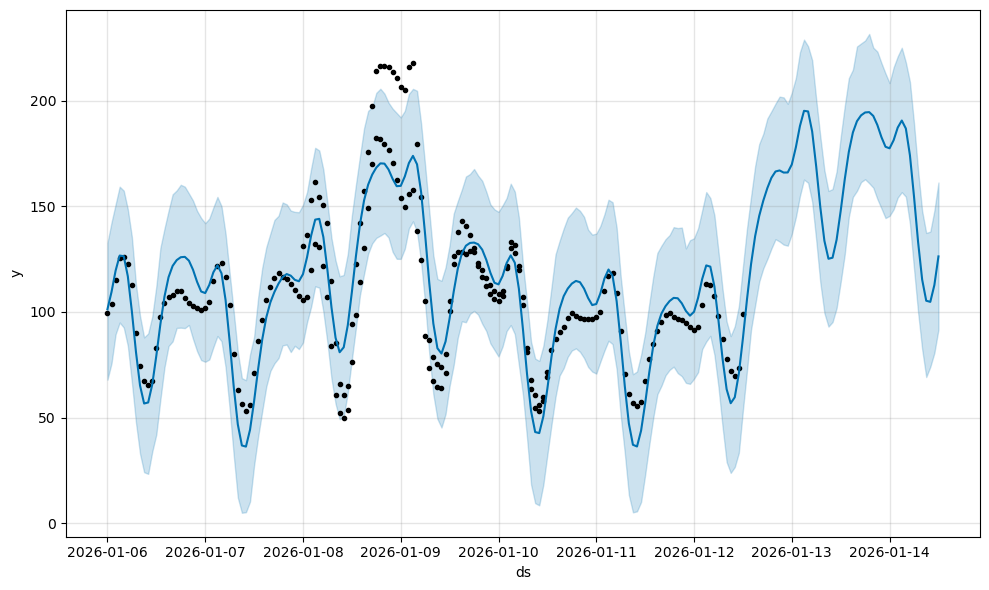

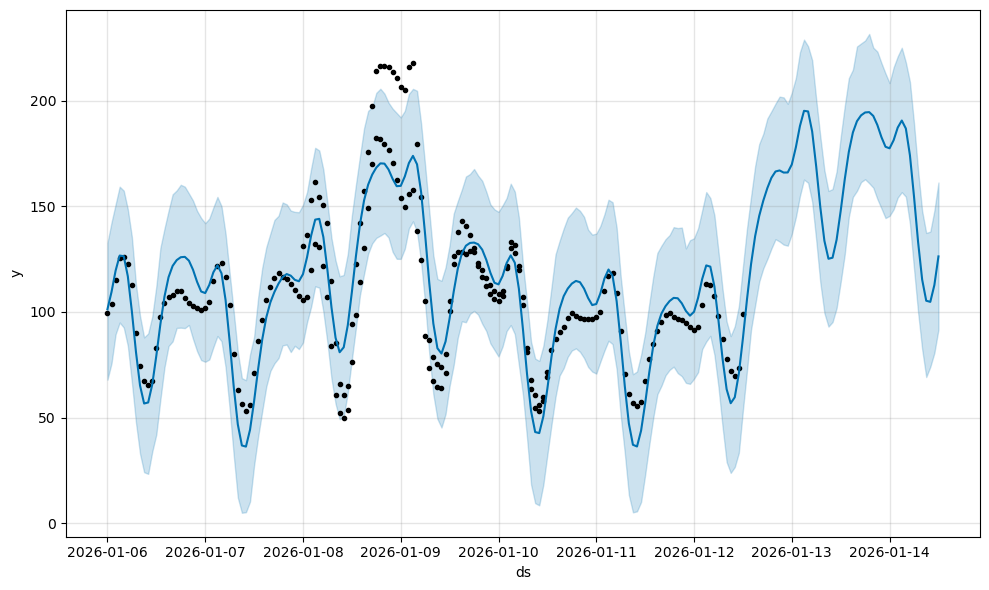

In [16]:
model.plot(forecast)

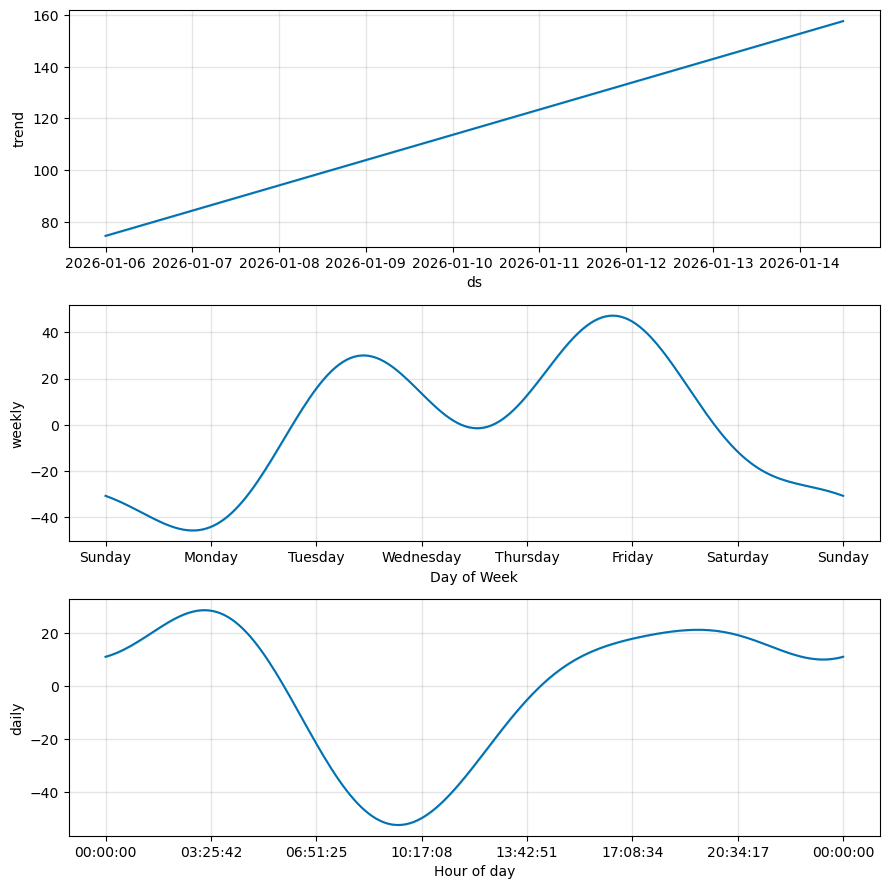

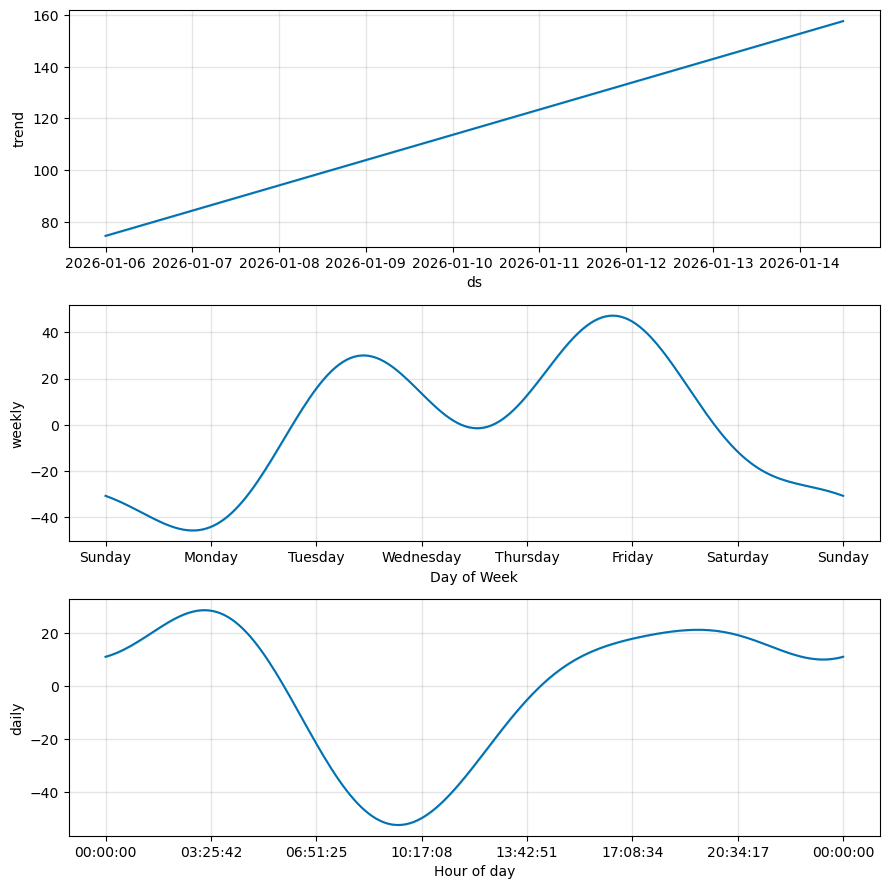

In [17]:
model.plot_components(forecast)

In [18]:
train = ts.iloc[:-48]
test = ts.iloc[-48:]

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True
)
m.fit(train)

future = m.make_future_dataframe(periods=48, freq="H")
fc = m.predict(future)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    test["y"],
    fc.iloc[-48:]["yhat"]
)

print("MAE:", mae)

12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\shrn1\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


MAE: 51.600156909276954


In [19]:
future = model.make_future_dataframe(periods=12, freq="H")

C:\Users\shrn1\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [20]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=False,
    yearly_seasonality=False
)

In [21]:
import numpy as np

ts["y"] = np.log1p(ts["y"])

In [22]:
forecast["yhat"] = np.expm1(forecast["yhat"])

In [23]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=False,
    yearly_seasonality=False,
    interval_width=0.9
)

In [24]:
baseline_pred = test["y"].shift(1).dropna()
baseline_true = test["y"].iloc[1:]

from sklearn.metrics import mean_absolute_error
mean_absolute_error(baseline_true, baseline_pred)

5.37872340425532

In [25]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("air_quality.db")
df = pd.read_sql("SELECT * FROM air_quality", conn)
conn.close()

df["datetime_utc"] = pd.to_datetime(df["datetime_utc"])

ts = df[
    (df["city"] == "Delhi") &
    (df["pollutant"] == "pm2_5")
].sort_values("datetime_utc")

ts = ts.set_index("datetime_utc")["value"]
ts.head()

datetime_utc
2026-01-06 00:00:00     99.7
2026-01-06 01:00:00    103.8
2026-01-06 02:00:00    115.3
2026-01-06 03:00:00    125.7
2026-01-06 04:00:00    126.2
Name: value, dtype: float64

In [26]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(ts.dropna())
print("ADF statistic:", adf[0])
print("p-value:", adf[1])

ADF statistic: -3.4329201086898347
p-value: 0.009886529500428011


In [27]:
ts_diff = ts.diff().dropna()

In [28]:
order = (1, 1, 1)
seasonal_order = (1, 0, 1, 24)

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = ts.iloc[:-12]   # last 12 hours for testing
test = ts.iloc[-12:]

model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
results.summary()

C:\Users\shrn1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shrn1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  206
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                -755.703
Date:                            Thu, 08 Jan 2026   AIC                           1521.406
Time:                                    12:29:19   BIC                           1537.343
Sample:                                         0   HQIC                          1527.868
                                            - 206                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5545      0.078     -7.076      0.000      -0.708      -0.401
ma.L1          0.0479      0.098      0.488      0.626      -0.144       0.240
ar.S.L24       0.4223      0.178      2.366      0.018       0.072       0.772
ma.S.L24      -0.3173      0.202     -1.571      0.116      -0.713       0.079
sigma2       268.2417     25.970     10.329      0.000     217.341     319.142
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                11.48
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

C:\Users\shrn1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\shrn1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


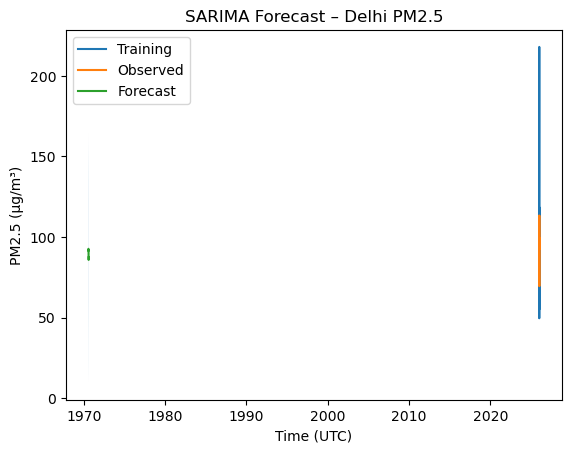

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train.index, train, label="Training")
plt.plot(test.index, test, label="Observed")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.3
)
plt.legend()
plt.title("SARIMA Forecast – Delhi PM2.5")
plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error

mae_sarima = mean_absolute_error(test, forecast_mean)
print("SARIMA MAE:", mae_sarima)

SARIMA MAE: 11.738344091515572
